Reference Solutions for Part 2 Question C. Convolutional Neural Networks on OCTMNIST
------------------------------------


There are many ways to approach this problem, this is just one. This notebook used code from some of the best solutions, so well done if you recognise something!


### C1 Data loading and inspection [2 marks]

In [ ]:
# Install medmnist
!python -m pip install medmnist  &> /dev/null

The syntax of the command is incorrect.


In [ ]:
# Imports
import numpy as np
import time

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils import data as torch_data

# For visualizing data
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import medmnist

from medmnist import INFO

#Set the seeds for reproducability.
SEED = 99999
torch.manual_seed(SEED)
np.random.seed(SEED)

print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v2.0.2 @ https://github.com/MedMNIST/MedMNIST/


C1 Data loading and inspection [3 mark]
---------------------------------------

In [ ]:
#Show dataset info
DS_INFO = INFO["octmnist"]
data_class = getattr(medmnist.dataset, DS_INFO["python_class"])

#Show the dataset information. 
#We see info on the number of classes (4), channels (1) and splits (train, val, test roughly 100:10:1 ratio). We can tell this is a MULTI-CLASS problem.
DS_INFO

{'python_class': 'OCTMNIST',
 'description': 'The OCTMNIST is based on a prior dataset of 109,309 valid optical coherence tomography (OCT) images for retinal diseases. The dataset is comprised of 4 diagnosis categories, leading to a multi-class classification task. We split the source training set with a ratio of 9:1 into training and validation set, and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−1,536)×(277−512). We center-crop the images and resize them into 1×28×28.',
 'url': 'https://zenodo.org/record/5208230/files/octmnist.npz?download=1',
 'MD5': 'c68d92d5b585d8d81f7112f81e2d0842',
 'task': 'multi-class',
 'label': {'0': 'choroidal neovascularization',
  '1': 'diabetic macular edema',
  '2': 'drusen',
  '3': 'normal'},
 'n_channels': 1,
 'n_samples': {'train': 97477, 'val': 10832, 'test': 1000},
 'license': 'CC BY 4.0'}

In [ ]:
#We need to download and normalise the data. ToTensor() transforms images from 0-255 to 0-1, and Normalize() centers the data around 0, between -1 to 1.
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.5), (0.5)), # Normalize the image data
    ])


train_dataset = data_class(split='train', download=True, transform=transform)
val_dataset = data_class(split='val', download=True,  transform=transform)
test_dataset = data_class(split='test', download=True,  transform=transform)

Using downloaded and verified file: C:\Users\Lawrence Schobs\.medmnist\octmnist.npz
Using downloaded and verified file: C:\Users\Lawrence Schobs\.medmnist\octmnist.npz
Using downloaded and verified file: C:\Users\Lawrence Schobs\.medmnist\octmnist.npz


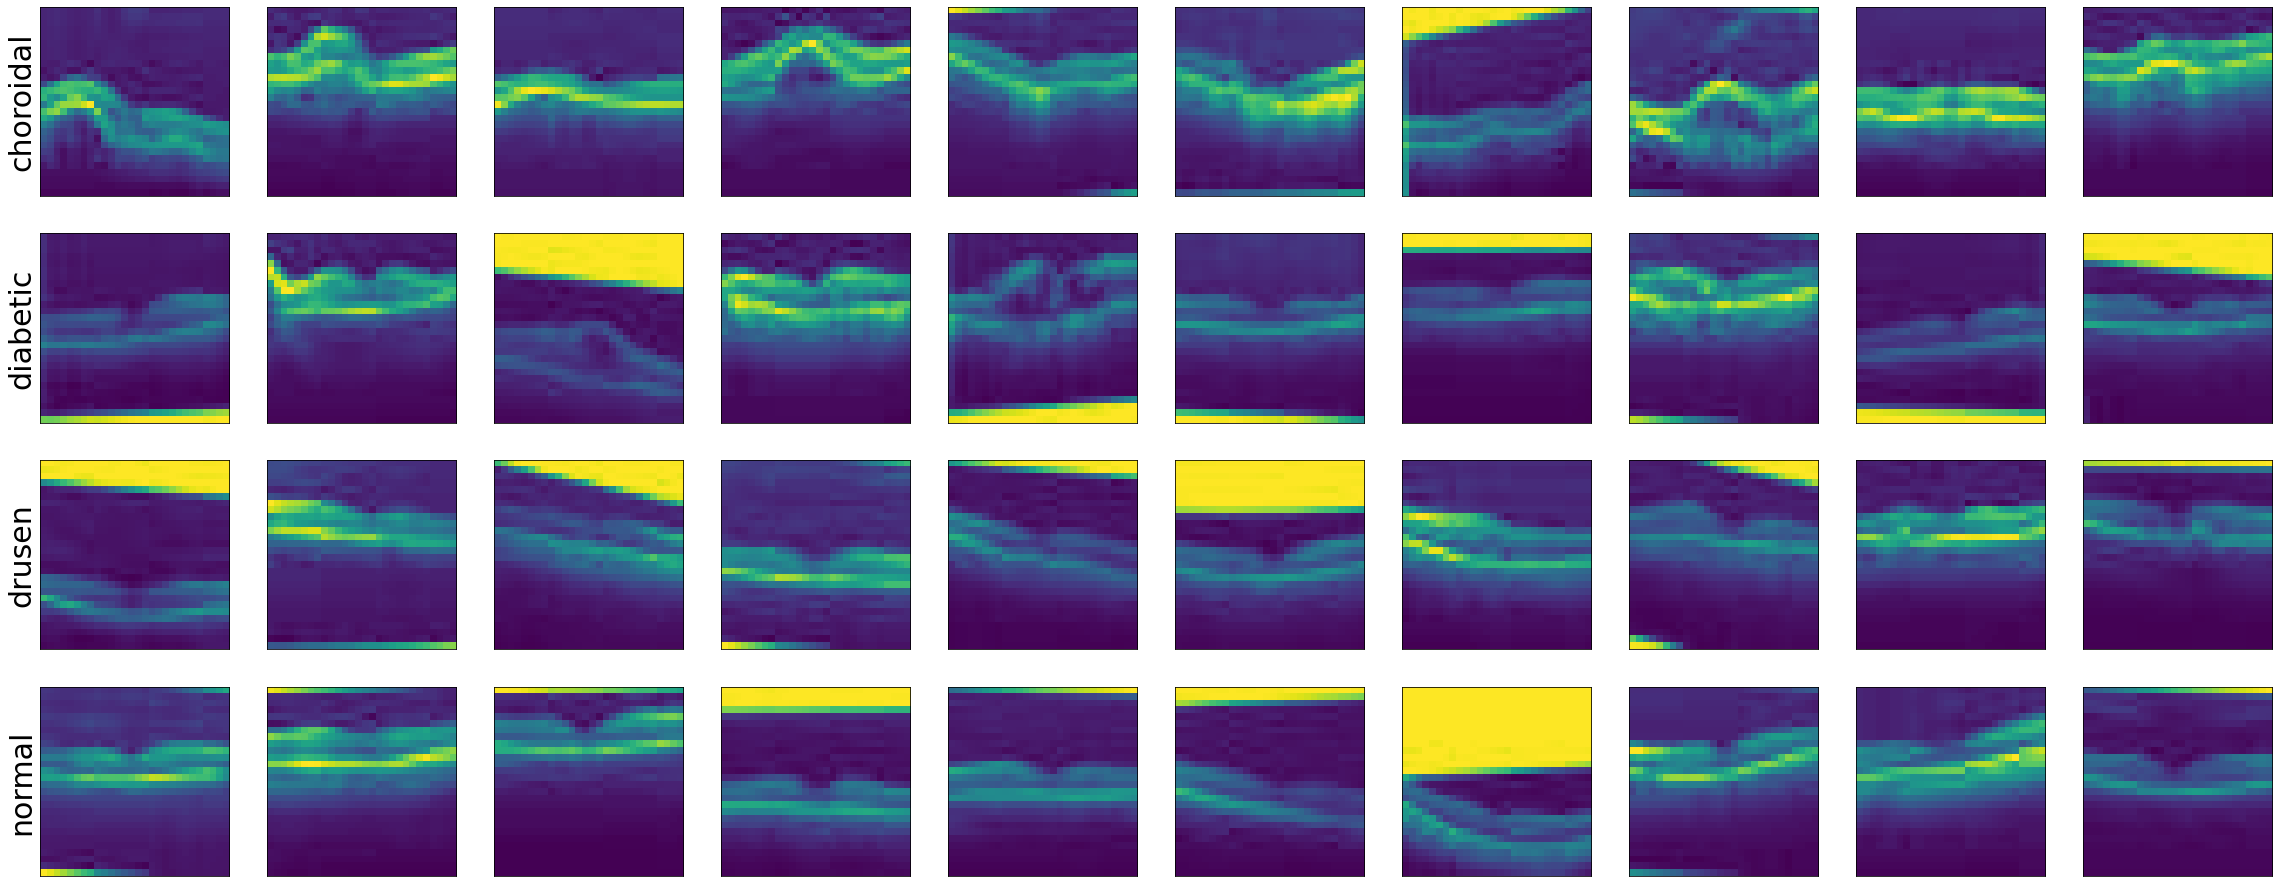

In [ ]:
#Function to display the images from the dataset given a class
def display_samples(data, labels, count=10):
    """
    Display 'count' images from the dataset 'data' with label from list of labels 'labels'
    '"""

     
    fig, ax= plt.subplots(len(labels), count, figsize=(4*count, 16))

    for label in labels:
      data_with_label = data.imgs[data.labels[:, 0] == label][:count]
      for ex_idx in range(len(data_with_label)):
        ax[label, ex_idx].imshow(data_with_label[ex_idx])

        #Turn off x,y ticks
        ax[label, ex_idx].set_yticks([])
        ax[label, ex_idx].set_xticks([])

      #Set the Y axis label
      ax[label, 0].set_ylabel( ylabel=DS_INFO["label"][str(label)].split(" ")[0], fontsize=30)
    
    plt.show()

display_samples(train_dataset, [0,1,2,3], 10)



## C2 Convolutional neural networks [4 marks]

Keep a record of the four metrics M1 to M4 below for the two models below:

**M1)** Training accuracy: the prediction accuracy of a trained model on the training dataset.

**M2)** Validation accuracy: the prediction accuracy of a trained model on the validation dataset.

**M3)** Testing accuracy: the prediction accuracy of a trained model on the test dataset.

**M4)** Training time: the time taken to train the model (i.e. to learn/estimate the learnable parameters) on the training dataset.

This question asks you to design convolutional neural networks (CNNs). Only the number of convolutional (Conv) layers and the number of fully connected (FC) layers will be specified below. You are free to design other aspects of the network. For example, you can use other types of operation (e.g. padding), layers (e.g. pooling, or preprocessing (e.g. augmentation), and you choose the number of units/neurons in each layer. Likewise, you may choose the number of epochs and many other settings according to your accessible computational power. 


a) Design a CNN with two Conv layers and two FC layers. Train the model on the training set, use the validation set to choose the best design among at least three different choices, and test the chosen model on the test set. Report the four metrics M1 to M4 **[2 marks]**

b) Design a CNN with three Conv layers and three FC layers. Train the model on the training set, use the validation set to choose the best design among at least three different choices, and test the chosen model on the test set. Report the four metrics M1 to M4 **[2 marks]**




In [ ]:
class ConvNet(nn.Module):
    """Pytorch Convolutional Neural Network  class.
        input_size: Int, dimension[0] of square image,
        output_classes: Number of output classes,
        out_channel_sizes: List of output channels, one for each convolutional layer,
        kernel_sizes: List of kernal sizes, one for each each convolutional layer,
        fc_sizes: Number of neurons in fully connected layer. Same # for each FC layer, **feel free to change to a list and experiment!**,
        num_layers: Number of FC and convolutional layers, default=2,
    """
    def __init__(self, input_size, output_classes,  out_channel_sizes, kernel_sizes, fc_sizes, num_layers=2):
        super(ConvNet, self).__init__()


        self.num_layers = num_layers


        self.conv_1 = nn.Conv2d(in_channels=1, out_channels=out_channel_sizes[0], kernel_size=kernel_sizes[0], padding= "same")
        self.conv_2 = nn.Conv2d(in_channels=out_channel_sizes[0], out_channels=out_channel_sizes[1], kernel_size=kernel_sizes[1], padding= "same")

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        #Linear layer has to match the last Conv Layer. We use maxpooling num_layers times hence the power! We use floor because it goes 28,14,7, 3.5 <-- maxpool rounds to 3
        first_linear_size = int(out_channel_sizes[-1]  * np.floor(input_size/(2**num_layers))* np.floor(input_size/(2**num_layers)))
        self.fc1 = nn.Linear(first_linear_size, fc_sizes)


        # For 3 layer we add an extra conv and add the intermediate FC layer
        if self.num_layers == 3:
          self.conv_3 = nn.Conv2d(in_channels=out_channel_sizes[1], out_channels=out_channel_sizes[2], kernel_size=kernel_sizes[2], padding= "same")
          self.fc2= nn.Linear(fc_sizes, fc_sizes) # we will use the same # of neurons for layer 3 for simplicity

        self.final_fc_layer = nn.Linear(fc_sizes, output_classes)
        
      
        self.relu=nn.ReLU()
        self.loss_fun = nn.CrossEntropyLoss()
        
    def forward(self, x):
        if self.num_layers == 2:
            x = self.maxpool(self.relu(self.conv_1(x)))
            x = self.maxpool(self.relu(self.conv_2(x)))
            x = torch.flatten(x, 1) # flatten all dimensions except batch
            x = self.relu(self.fc1(x))
            x = self.final_fc_layer(x) #no ReLU  final layer, otherwise we throw away useful info! 

        else:
            x = self.maxpool(self.relu(self.conv_1(x)))
            x = self.maxpool(self.relu(self.conv_2(x)))
            x = self.maxpool(self.relu(self.conv_3(x)))
            x = torch.flatten(x, 1) # flatten all dimensions except batch
            x = self.relu(self.fc1(x))
            x = self.relu(self.fc2(x)) 
            x = self.final_fc_layer(x) #no ReLU  final layer, otherwise we throw away useful info! 
        return x


    
    def fit(self, train_loader, val_loader, epochs=10, lr=0.001, weight_decay=0.01, verbose=True):
        """Train the model using minibatch Adam optimizer with weight decay. 
        train_loader: DataLoader object for training set,
        val_loader: DataLoader object for validation set,
        epochs: number of epochs to train for default=10,
        lr: Learning Rate, default=0.01
        weight_decay: Weight decay or L2 penalty, for L2 Regularization. Default=0.01,
        verbose: boolean whether to print out epochs, default=True
        """
        optimizer = torch.optim.AdamW(self.parameters(), lr=lr, weight_decay=weight_decay)
        
        start_time = time.time()
        # Training
        for ep in range(epochs):
            for itr,batch in enumerate(train_loader):
                batch_x,batch_y = batch

                batch_y = torch.squeeze(batch_y.to(torch.float32))
                # Training steps
                optimizer.zero_grad()
                pred_y = self.forward(batch_x)
                # Compute the cost

                cost = self.loss_fun(pred_y, batch_y.long())
                # Track the loss
                loss_value = cost.item()
                
                # Update the parameters
                cost.backward()
                optimizer.step()

                # End of inner for loop, Report the training loss every  epoch
            if ep % 5 == 0 and verbose:
                print(f'Epoch:{ep} Val accuracy: {self.score(val_loader)}')
        
        return time.time() - start_time
    def predict(self, X):
        """Return class prediction for an example."""
        # Make sure the tensors are detached
        with torch.no_grad():
            preds = self.forward(X)
            preds = preds.round()
            return preds

    def score(self, dataloader):
        """Compute the score on a dataset."""
        correct = 0
        # Make sure the tensors are detached
        with torch.no_grad():
          for itr,batch in enumerate(dataloader):
            images, labels = batch
            labels = torch.squeeze(labels)
            _, preds = torch.max(self.predict(images),1)
            correct += (preds == labels).sum().item()

        return (correct/len(dataloader.dataset))
      

C2a) Run the 2 layer CNN with a basic parameter search. We keep track of M1, M2, M3 and M4 for the best model

In [ ]:
#First, lets make our data loader. We need to pick a batch size.
batch_size=256
train_loader = torch_data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch_data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch_data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

#You can see how we can easily add parameters to our CNN class to make changes e.g. add a class param for max pooling on/off, dropout, padding etc.
#We need to define some parameters to search. Our CNN class is quite flexible, but we'll only change 1 parameter at a time in this example.
#We'll only change the size of the second FC layer (remember, the first FC layer is defined by architecture and input size).

#reusable function for our 2 and 3 layer CNN to find best params.
def parameter_search(fc_layer_opts, cnn_params):
  """ Perform a parameter search over options of # neurons in the second FC layer.
        fc_layer_opts: List of FC neurons to test,
        cnn_params: Dict with keys for default CNN parameters: out_channel_sizes, kernel_sizes, num_layers 
  """
  #Keep track of validation scores
  fc_M2s = np.zeros(3)
  for i, fc_opt in enumerate(fc_layer_opts):
    print("\n \n Experiment ", i, ": For FC2 Layer size: ", fc_opt, "\n ")
    
    #train the CNN
    my_cnn = ConvNet(input_size=28, output_classes=4,  out_channel_sizes=cnn_params['out_channel_sizes'], kernel_sizes=cnn_params['kernel_sizes'], fc_sizes=fc_opt, num_layers=cnn_params['num_layers'])
    time_taken = my_cnn.fit(train_loader, val_loader, epochs=5)

    #Validate the CNN
    val_acc = my_cnn.score(val_loader)
    fc_M2s[i] = val_acc

    print("Experiment: ", i , " Validation acc: ", val_acc)

  # pick the best number of FC layers
  best_fc = fc_layer_two_opts[np.argmax(fc_M2s)]
  return best_fc


In [ ]:

#Here we train the 2 layer CNN models. We define the default params that do not change over experiments
two_layer_params = {"out_channel_sizes":[3,5], "kernel_sizes":[5,5], "num_layers":2}

#FC layer 2: # neurons we are testing
fc_layer_two_opts = [1,5,100]

best_fc_two_layer = parameter_search(fc_layer_two_opts, two_layer_params)



 
 Experiment  0 : For FC2 Layer size:  1 
 
Epoch:0 Val accuracy: 0.47211964549483015
Experiment:  0  Validation acc:  0.3435192023633678

 
 Experiment  1 : For FC2 Layer size:  5 
 
Epoch:0 Val accuracy: 0.4967688330871492
Experiment:  1  Validation acc:  0.7277511078286558

 
 Experiment  2 : For FC2 Layer size:  100 
 
Epoch:0 Val accuracy: 0.6995014771048744
Experiment:  2  Validation acc:  0.7703101920236337


In [ ]:
#Refit with best params and calcuate M1, M2, M3, M4. It would be a good idea to train for more epochs here!
best_cnn_2layer = ConvNet(input_size=28, output_classes=4,  out_channel_sizes=two_layer_params['out_channel_sizes'], kernel_sizes=two_layer_params['kernel_sizes'], 
            fc_sizes=best_fc_two_layer, num_layers=two_layer_params['num_layers'])
            
time_taken =  best_cnn_2layer.fit(train_loader, val_loader, epochs=5)  

cnn_2_layer_scores = {}
# compute metrics
cnn_2_layer_scores["M1"] = best_cnn_2layer.score(train_loader)
cnn_2_layer_scores["M2"] = best_cnn_2layer.score(val_loader)
cnn_2_layer_scores["M3"] = best_cnn_2layer.score(test_loader)
cnn_2_layer_scores["M4"] = time_taken

print("Metrics for best model:")
print(cnn_2_layer_scores)

Epoch:0 Val accuracy: 0.715288035450517
Metrics for best model:
{'M1': 0.7894272495050114, 'M2': 0.7900664697193501, 'M3': 0.598, 'M4': 80.04502725601196}


In [ ]:
# We perform the same experiment as before, but this time use 3 layers for our CNN. This is chosen in the num_layers key. 
three_layer_params = {"out_channel_sizes":[3,5, 7], "kernel_sizes":[5,5, 7], "num_layers":3}
fc_layer_three_opts = [1,5,100]

best_fc_three_layer = parameter_search(fc_layer_three_opts, three_layer_params)




 
 Experiment  0 : For FC2 Layer size:  1 
 
Epoch:0 Val accuracy: 0.3435192023633678
Experiment:  0  Validation acc:  0.3435192023633678

 
 Experiment  1 : For FC2 Layer size:  5 
 
Epoch:0 Val accuracy: 0.3435192023633678
Experiment:  1  Validation acc:  0.740029542097489

 
 Experiment  2 : For FC2 Layer size:  10 
 
Epoch:0 Val accuracy: 0.6879615952732644
Experiment:  2  Validation acc:  0.7848966026587888


In [ ]:
#Again, we refit with best params and calcuate M1, M2, M3, M4
best_cnn_3layer = ConvNet(input_size=28, output_classes=4,  out_channel_sizes=three_layer_params['out_channel_sizes'], kernel_sizes=three_layer_params['kernel_sizes'], 
            fc_sizes=best_fc_three_layer, num_layers=three_layer_params['num_layers'])
            
time_taken =  best_cnn_3layer.fit(train_loader, val_loader, epochs=5)  

cnn_3_layer_scores = {}
# compute metrics
cnn_3_layer_scores["M1"] = best_cnn_3layer.score(train_loader)
cnn_3_layer_scores["M2"] = best_cnn_3layer.score(val_loader)
cnn_3_layer_scores["M3"] = best_cnn_3layer.score(test_loader)
cnn_3_layer_scores["M4"] = time_taken

print("Metrics for best model:")
print(cnn_3_layer_scores)

Epoch:0 Val accuracy: 0.669682422451994
Metrics for best model:
{'M1': 0.7916739333381207, 'M2': 0.7911742983751846, 'M3': 0.595, 'M4': 82.33568716049194}


C3 Performance comparison (2 marks)
-----------------------------------

The optimal FC layers for our 2 layer CNN:  100
The optimal FC layers for our 3 layer CNN:  100


<Figure size 72x144 with 0 Axes>

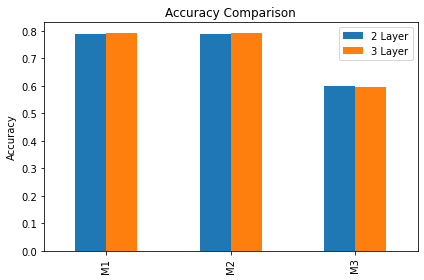

<Figure size 72x144 with 0 Axes>

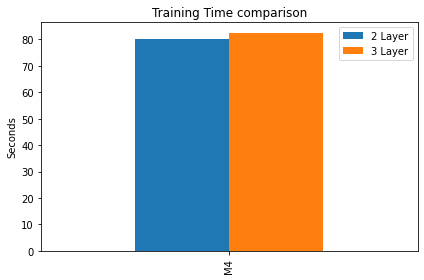

In [ ]:
# pandas makes it easy to plot bar charts 
import pandas as pd
# add to data frame 
scores = pd.DataFrame(columns=["M1", "M2", "M3"])
scores.loc["2 Layer"] =  [cnn_2_layer_scores[x] for x in ['M1', 'M2', 'M3']] 
scores.loc["3 Layer"] =  [cnn_3_layer_scores[x] for x in ['M1', 'M2', 'M3']] 
# this makes it so the metrics are grouped 
scores = scores.T

print("The optimal FC layers for our 2 layer CNN: ", best_fc_two_layer)
print("The optimal FC layers for our 3 layer CNN: ", best_fc_three_layer)


fig = plt.figure(figsize=(1, 2))
scores.plot( y=["2 Layer", "3 Layer"], kind="bar", fig=fig)
plt.title("Accuracy Comparison")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.legend(loc=1)
plt.show()

times = pd.DataFrame(columns=["M4"])
times.loc["2 Layer"] = cnn_2_layer_scores['M4']
times.loc["3 Layer"] = cnn_3_layer_scores['M4']
# this makes it so the metrics are grouped 
times = times.T

fig2 = plt.figure(figsize=(1, 2))
times.plot( y=["2 Layer", "3 Layer"], kind="bar", fig=fig2)
plt.title("Training Time comparison")
plt.ylabel("Seconds")
plt.tight_layout()
plt.legend(loc=1)
plt.show()

Observations 
------------

* Our validation score is higher than our test score. By choosing hyperparameters based on our validation set, we may have overfitted our model to the validation set, or more likely the validation set has different properties to our test set. 

* The training time between our 2 layer and 3 layer CNNs is very close. Is this surprising? Well no! In CNNs the actually convolutions are very fast, it's the Fully connected layers that take up the most memory and time to back propagate through. This is because every neuron is connected to every other neuron. In our case, we are using very few FC neurons (only 100) so this difference in training time is negligible. In fact, because our third Conv layer uses another maxpooling, that's decreasing the amount of features into the first FC layer!

* We only trained for a few epochs so the difference in performance is quite small. If you increase the number of epochs and the neurons in the FC layers, you should see an increase in performance. The 3 layer CNN would get a better accuracy, but take longer to train.

* The CNN class is very flexible, feel free to play around with some parameters!